In [1]:
print("Importing Library...")
import torch
import torchvision
import torch.utils.data as putils

from torch import nn, optim
from torchvision import datasets,transforms
from torch.autograd import Variable
from PIL import Image
import numpy
import numpy as np

print("Importing Library Success")


Importing Library...
Importing Library Success


In [2]:
print("Creating Class...")

class Codec():
    def __init__(self, size, interpolate_size, mode):
        self.size = size
        self.interpolate_size = interpolate_size
        self.mode = mode

    def btc(self, image):
        if image.shape[0] % self.size != 0:
            n = ((self.size * int(image.shape[0] / self.size)) + self.size) - image.shape[0]
            image = numpy.pad(array=image, pad_width=(0, n))

        x = image.shape[0] / self.size
        y = image.shape[1] / self.size
        block_image = numpy.split(numpy.concatenate(numpy.split(image, y, axis=1)), x * y)
        for i in range(len(block_image)):
            mean = numpy.mean(numpy.mean(block_image[i], axis=1))
            std = numpy.std(block_image[i])
            m = self.size * self.size
            q = numpy.sum(block_image[i] > mean)

            a = mean - std * numpy.sqrt(q / (m - q))
            b = mean + std * numpy.sqrt((m - q) / q)

            block_image[i][block_image[i] > mean] = b
            block_image[i][block_image[i] < mean] = a

        block_image = numpy.concatenate(block_image)
        block_image = numpy.split(block_image, x)

        temp = numpy.concatenate(block_image, axis=1)

        if image.shape[0] % self.size != 0:
            temp = temp[1:-n + 1, 1:-n + 1]

        return torch.Tensor(temp)

    def BlockTruncationCoding(self, images_tensor):
        results_tensor = images_tensor.new_empty(size=images_tensor.size())
        for i in range(len(images_tensor)):
            compact_image = images_tensor[i][0]
            compressed_image = self.btc(compact_image)
            results_tensor[i][0] = compressed_image
        return results_tensor

    def Interpolate(self, image):
        return nn.functional.interpolate(input=image, scale_factor=self.interpolate_size, mode=self.mode,
                                         align_corners=False)

class RecCNN(nn.Module):
    def __init__(self, channel):
        super(RecCNN, self).__init__()
        self.deconv1 = nn.Conv2d(channel, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64, affine=False)
        self.deconv_n = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn_n = nn.BatchNorm2d(64, affine=False)
        self.deconv3 = nn.ConvTranspose2d(64, channel, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.deconv1(x))
        for _ in range(18):
            out = self.relu(self.bn_n(self.deconv_n(out)))
        out = self.deconv3(out)
        final = out.add(x)
        return final, out
class ComCNN(nn.Module):
    def __init__(self, channel):
        super(ComCNN, self).__init__()
        self.conv1 = nn.Conv2d(channel, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64, affine=False)
        self.conv3 = nn.Conv2d(64, channel, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.bn1(self.conv2(out)))
        return self.conv3(out)


def loss_function_l1(reconstructed_image,original_image):
    return nn.MSELoss(size_average=False)(reconstructed_image,original_image)

def loss_function_l2(residual_image,decoded_image,original_image):
    return nn.MSELoss(size_average=False)(residual_image,original_image-decoded_image)

print("Creating Class Success")
 

Creating Class...
Creating Class Success


In [3]:
print("Load Image Dataset")
train_image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
    transforms.Normalize((105.97411112882654,),(63.11390135470555,))
])

test_image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
    transforms.Normalize((85.35398198341836,),(65.0054783896806,))
])


train_path = '../dataset/train/'
test_path = '../dataset/test/'
train_dataset = torchvision.datasets.ImageFolder(
    root=train_path,
    transform=train_image_transform
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=test_image_transform
)

test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,
                                          shuffle=True,num_workers=2)

print("Load Image Dataset Success")



Load Image Dataset
Load Image Dataset Success


In [4]:
print("Initialize Model....")
CUDA = torch.cuda.is_available()

codec = Codec(4,2,'bicubic')

if CUDA:
    comCNN = ComCNN(1).cuda()
    recCNN = RecCNN(1).cuda()
    print("Cuda is available, using gpu instead")
else:
    comCNN = ComCNN(1)
    recCNN = RecCNN(1)
    print("Cuda is not available, using cpu instead")

comCNNOptimizer = optim.Adam(comCNN.parameters(),lr=1e-3)

recCNNOptimizer = optim.Adam(recCNN.parameters(),lr=1e-3)

print("Initialize Model Success")


Initialize Model....
Cuda is available, using gpu instead
Initialize Model Success


In [5]:
import time
print("Begin Training....")
epochs = 50
comCNN.train()
recCNN.train()
graph_l1 = np.empty(epochs)
graph_l2 = np.empty(epochs)
global_start = time.time()
for epoch in range(epochs):
    start = time.time()
    train_loss_1 = 0
    train_loss_2 = 0
    for batch_idx,(data,_) in enumerate(train_loader):
        
        data = Variable(data)
        
        compact_image = comCNN(data.cuda())
        compact_image_temp = compact_image.cpu().detach()
        compressed_image_btc = codec.BlockTruncationCoding(compact_image_temp)
        upscaled_image_btc = codec.Interpolate(compressed_image_btc)
        
        torch.cuda.empty_cache()
        
        # update beta with eq 5
    
        recCNNOptimizer.zero_grad()
        reconstructed_image,residual = recCNN(upscaled_image_btc.cuda())
        loss2 = loss_function_l2(
            residual_image=residual,
            decoded_image=upscaled_image_btc.cuda(),
            original_image=data.cuda()
        )
        loss2.backward()
        
        train_loss_2 += loss2.item()
        recCNNOptimizer.step()
    
    
        comCNNOptimizer.zero_grad()
        upscaled_image_nonbtc = codec.Interpolate(compact_image)
        reconstructed_without_btc,_ = recCNN(upscaled_image_nonbtc.cuda())
        loss1 = loss_function_l1(
            reconstructed_image=reconstructed_without_btc.cuda(),
            original_image=data.cuda()
        )
        loss1.backward()
        train_loss_1 += loss1.item()
        comCNNOptimizer.step()
        # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} - {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader),
        #         loss1.item() / len(data) , loss2.item()/len(data)))
    end = time.time()
    graph_l1[epoch] = train_loss_1/len(train_loader.dataset)
    graph_l2[epoch] = train_loss_2/len(train_loader.dataset)
    print('====> Epoch: {}\nAverage loss 1: {:.4f}\nAverage Loss 2: {:.4f}\nRunning Time : {}'.format(
          epoch, train_loss_1/len(train_loader.dataset),train_loss_2/len(train_loader.dataset),(end-start)))

global_end = time.time()
print("\n========>Training Complete....")
print('Total Running Time : {}'.format((global_end-global_start)))

Begin Training....
====> Epoch: 0
Average loss 1: 33724.2991
Average Loss 2: 38206.2141
Running Time : 19.61069416999817
====> Epoch: 1
Average loss 1: 4146.6972
Average Loss 2: 4616.0969
Running Time : 13.101742506027222
====> Epoch: 2
Average loss 1: 1407.3147
Average Loss 2: 1442.4496
Running Time : 12.537521600723267
====> Epoch: 3
Average loss 1: 918.7409
Average Loss 2: 728.5411
Running Time : 12.420795440673828
====> Epoch: 4
Average loss 1: 448.7482
Average Loss 2: 319.5321
Running Time : 12.67118501663208
====> Epoch: 5
Average loss 1: 200.0275
Average Loss 2: 161.7914
Running Time : 12.564449310302734
====> Epoch: 6
Average loss 1: 111.1691
Average Loss 2: 114.3468
Running Time : 12.29818868637085
====> Epoch: 7
Average loss 1: 74.0542
Average Loss 2: 86.1845
Running Time : 12.436760425567627
====> Epoch: 8
Average loss 1: 62.3926
Average Loss 2: 71.5521
Running Time : 12.790975570678711
====> Epoch: 9
Average loss 1: 57.3775
Average Loss 2: 62.8966
Running Time : 12.48467731

d:\pycharmprojects\end-to-end-compression-framework\venv\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
d:\pycharmprojects\end-to-end-compression-framework\venv\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in long_scalars
d:\pycharmprojects\end-to-end-compression-framework\venv\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply


In [8]:
print("Saving Model...")
torch.save(comCNN.state_dict(),'../model/end-to-end-with-btc')
print("Model saved")

Saving Model...
Model saved


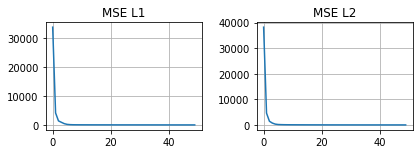

In [7]:
import matplotlib.pyplot as plt
plt.figure(1)

plt.subplot(221)
plt.plot(graph_l1)
plt.title("MSE L1")
plt.grid(True)

plt.subplot(222)
plt.plot(graph_l2)
plt.title('MSE L2')
plt.grid(True)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()


In [9]:
# TODO Create psnr comparation end-to-end vs btc